In [1]:
# ruff: noqa: N802, N803, N806, N815, N816
import os

import matplotlib.pyplot as plt
import numpy as np

import archimedes as arc

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

np.random.seed(0)

# Parameter Estimation

This page shows how to implement nonlinear system identification workflows in Python using Archimedes.
System identification in Archimedes combines a flexible prediction error method (PEM) workflow with automatic differentiation and structured parameter handling.
Instead of manually coding gradients or managing flat parameter vectors, you can focus on your model physics while Archimedes handles the optimization details automatically.


```{image} _static/sysid_workflow.png
:class: only-light
```

```{image} _static/sysid_workflow.png
:class: only-dark
```


## Basic PEM Setup

Let's start with a simple second-order oscillator model. Here's synthetic step response data from a mass-spring-damper system:

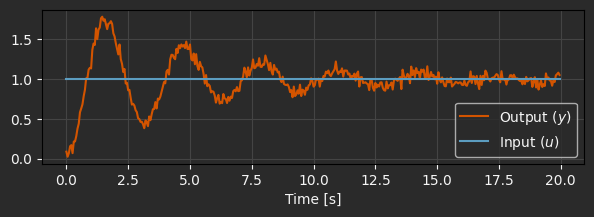

In [2]:
# Load step response data
raw_data = np.loadtxt("data/oscillator_step.csv", skiprows=1, delimiter="\t")
data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Output ($y$)")
ax.plot(data.ts, data.us[0], label="Input ($u$)")
ax.set_xlabel("Time [s]")
ax.grid()
ax.legend()


The [`pem`](#archimedes.sysid.pem) function solves parameter estimation problems for discrete-time state-space models of the form:

\begin{align}
x_{k+1} &= f(t_k, x_k, u_k; p) + w_k \\
y_k &= h(t_k, x_k, u_k; p) + v_k,
\end{align}

where $t$ is the time, $x$ are the system states, $u$ are the control inputs, and $p$ are the system parameters.
The process noise $w$ and measurement noise $v$ are assumed to be Gaussian-distributed with covariance matrices $Q$ and $R$, respectively.
We will refer to $f$ as the "dynamics" function and $h$ as the "observation" function.

Define the system model using standard NumPy operations:

In [3]:
# Mass-spring-damper model
nx = 2  # State dimension
nu = 1  # Input dimension
ny = 1  # Output dimension
dt = data.ts[1] - data.ts[0]


@arc.discretize(dt=dt, method="rk4")
def dyn(t, x, u, p):
    x1, x2 = x
    omega_n, zeta = p
    x2_t = -(omega_n**2) * x1 - 2 * zeta * omega_n * x2 + omega_n**2 * u[0]
    return np.hstack([x2, x2_t])


# Observation model
def obs(t, x, u, p):
    return x[0]  # Observe position

Now estimate the unknown parameters `[omega_n, zeta]`:


In [4]:
# Set up noise estimates
noise_var = 0.5 * np.var(np.diff(data.ys[0]))
R = noise_var * np.eye(ny)  # Measurement noise
Q = 1e-2 * noise_var * np.eye(nx)  # Process noise

# Extended Kalman Filter for predictions
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)

# Estimate parameters
params_guess = np.array([2.5, 0.1])  # Initial guess for [omega_n, zeta]
result = arc.sysid.pem(ekf, data, params_guess, x0=np.zeros(2))

print(f"Estimated natural frequency: {result.p[0]:.4f} rad/s")
print(f"Estimated damping ratio:     {result.p[1]:.4f}")

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         6.4404e-01                                   3.77e+00  
    1           3         5.0769e-01       1.36e-01       6.64e-01     3.10e-01  
    2           4         5.0692e-01       7.69e-04       4.30e-02     1.17e-03  
    3           5         5.0692e-01       5.06e-08       3.05e-04     9.73e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Estimated natural frequency: 1.9975 rad/s
Estimated damping ratio:     0.0923


That's it! The `pem` function handles gradient computation, optimization, and numerical details automatically.

Text(0.5, 1.0, 'Step response')

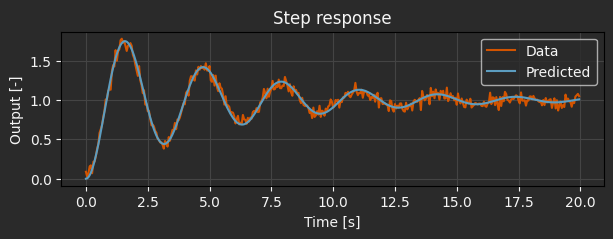

In [5]:
# Predicted step response with optimized parameters
xs_pred = np.zeros((nx, len(data.ts)))
ys_pred = np.zeros((ny, len(data.ts)))
for i in range(len(data.ts)):
    ys_pred[:, i] = obs(data.ts[i], xs_pred[:, i], data.us[:, i], result.p)
    if i < len(data.ts) - 1:
        xs_pred[:, i + 1] = dyn(data.ts[i], xs_pred[:, i], data.us[:, i], result.p)

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Data")
ax.plot(data.ts, ys_pred[0], label="Predicted")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Output [-]")
ax.grid()
ax.legend()
ax.set_title("Step response")

## Estimating initial conditions

If the initial conditions are unknown, they can be included as additional parameters to be estimated.  To optimize the initial conditions, simply add the `estimate_x0=True` flag to the `pem` call:

In [6]:
x0_guess = np.array([1.0, 0.0])  # Initial guess for state
result = arc.sysid.pem(ekf, data, params_guess, x0=x0_guess, estimate_x0=True)

x0_opt, params_opt = result.x0, result.p
print(f"Estimated initial condition: {x0_opt}")
print(f"Estimated natural frequency: {params_opt[0]:.4f} rad/s")
print(f"Estimated damping ratio:     {params_opt[1]:.4f}")

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         6.4046e-01                                   3.77e+00  
    1           3         5.0409e-01       1.36e-01       6.64e-01     3.11e-01  
    2           4         5.0331e-01       7.71e-04       4.30e-02     1.18e-03  
    3           5         5.0331e-01       5.17e-08       3.07e-04     9.97e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Estimated initial condition: [ 0.09375274 -0.20830341]
Estimated natural frequency: 1.9976 rad/s
Estimated damping ratio:     0.0922


Text(0.5, 1.0, 'Step response')

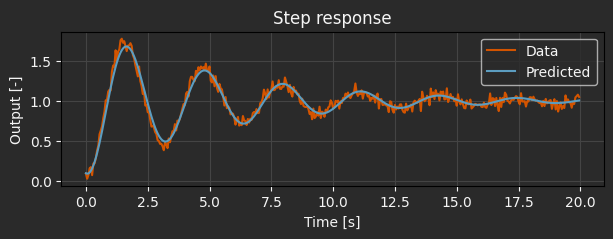

In [7]:
# Predicted step response with optimized parameters and initial state
xs_pred = np.zeros((nx, len(data.ts)))
ys_pred = np.zeros((ny, len(data.ts)))
xs_pred[:, 0] = x0_opt  # Set initial state
for i in range(len(data.ts)):
    ys_pred[:, i] = obs(data.ts[i], xs_pred[:, i], data.us[:, i], result.p)
    if i < len(data.ts) - 1:
        xs_pred[:, i + 1] = dyn(data.ts[i], xs_pred[:, i], data.us[:, i], result.p)

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Data")
ax.plot(data.ts, ys_pred[0], label="Predicted")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Output [-]")
ax.grid()
ax.legend()
ax.set_title("Step response")


## Structured Parameters

For complex systems with multiple subsystems, flat parameter vectors become unwieldy. Archimedes supports hierarchical parameter structures. These "structured data types" can be as simple as a dict:

In [8]:
params_guess = {"omega_n": 2.5, "zeta": 0.1}


# Access parameters naturally in the model
@arc.discretize(dt=dt, method="rk4")
def dyn(t, x, u, params):
    x1, x2 = x
    omega_n, zeta = params["omega_n"], params["zeta"]

    x2_t = -(omega_n**2) * x1 - 2 * zeta * omega_n * x2 + omega_n**2 * u[0]

    return np.hstack([x2, x2_t])


# Extended Kalman Filter for predictions
# This avoids drift and handles noise and partial observability
ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R)

# Estimate parameters
result = arc.sysid.pem(ekf, data, params_guess, x0=np.zeros(2))

# Results are returned as the same data structure as the initial guess
print("Optimized parameters:", result.p)

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         6.4404e-01                                   3.77e+00  
    1           3         5.0769e-01       1.36e-01       6.64e-01     3.10e-01  
    2           4         5.0692e-01       7.69e-04       4.30e-02     1.17e-03  
    3           5         5.0692e-01       5.06e-08       3.05e-04     9.73e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Optimized parameters: {'omega_n': array(1.9975257), 'zeta': array(0.09226173)}


The parameters (or even the model itself) can also be a nested structure composed of custom classes.
This allows you to create reusable components, define standardized interfaces, and construct hierarchical models of the system.
See the documentation pages on [Structured Data Types](../../../trees.md) and [Hierarchical Design Patterns](../../../generated/notebooks/modular-design.md) for more information.

## Parameter Bounds

Physical systems often have known parameter bounds. Archimedes supports box constraints with the same parameter structure:

In [9]:
# Parameter bounds with same structure as initial guess
lower_bounds = {"omega_n": 0.1, "zeta": 0.01}
upper_bounds = {"omega_n": 10.0, "zeta": 2.0}

result = arc.sysid.pem(
    ekf, data, params_guess, x0=np.zeros(2), bounds=(lower_bounds, upper_bounds)
)

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         6.4404e-01                                   3.77e+00  
    1           3         5.0769e-01       1.36e-01       6.64e-01     3.10e-01  
    2           4         5.0692e-01       7.69e-04       4.30e-02     1.17e-03  
    3           5         5.0692e-01       5.06e-08       3.05e-04     9.73e-06  
Both actual and predicted relative reductions in the sum of squares are at most ftol


## Missing data

In practice, engineering data often has missing or corrupted data points due to sensor faults, power supply glitches, or other issues that are unrelated to the dynamics we're trying to model.
One way to approach this problem is to do careful preprocessing to try to fill in missing data.
However, in a PEM framework this can be handled by simply skipping the Kalman filter correction step, essentially using the model with the current parameters to "forecast through" the missing data with no penalty for deviation from the corrupted values.

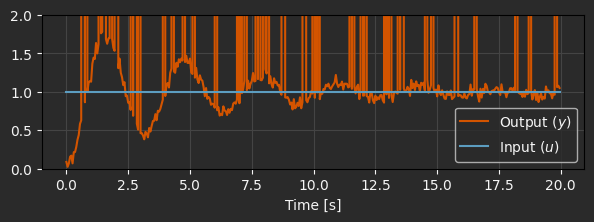

In [16]:
# Load step response data
raw_data = np.loadtxt("data/oscillator_step.csv", skiprows=1, delimiter="\t")

# Artificially corrupt some data points
MISSING_VALUE = 1e6  # Arbitrary value to represent missing data
corruption_indices = np.random.choice(len(raw_data), size=50, replace=False)
raw_data[corruption_indices, 2] = MISSING_VALUE

data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(data.ts, data.ys[0], label="Output ($y$)")
ax.plot(data.ts, data.us[0], label="Input ($u$)")
ax.set_xlabel("Time [s]")
ax.set_ylim([0, 2])
ax.grid()
ax.legend()

To handle the missing data properly, the only modification needed is to provide a function to the Kalman filter that flags when data is considered "missing".  Note that NaN and infinite checks can't be handled symbolically, so it is safer to use a numeric test - in this case, a large known value out of the measurement range.

In [17]:
def is_missing(y):
    return y == MISSING_VALUE


ekf = arc.observers.ExtendedKalmanFilter(dyn, obs, Q, R, missing=is_missing)

# Estimate parameters
result = arc.sysid.pem(ekf, data, params_guess, x0=np.zeros(2))

print(f"Estimated natural frequency: {result.p['omega_n']:.4f} rad/s")
print(f"Estimated damping ratio:     {result.p['zeta']:.4f}")

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         6.0194e-01                                   3.79e+00  
    1           3         4.5791e-01       1.44e-01       6.81e-01     3.81e-01  
    2           4         4.5677e-01       1.14e-03       5.14e-02     1.38e-03  
    3           5         4.5677e-01       7.35e-08       3.62e-04     1.37e-05  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Estimated natural frequency: 1.9978 rad/s
Estimated damping ratio:     0.0927


## Multiple Experiments

System identification often uses multiple datasets to ensure model robustness and capture different aspects of system behavior. Pass a list of datasets to optimize against all experiments simultaneously:


In [14]:
raw_data = np.loadtxt("data/oscillator_step.csv", skiprows=1, delimiter="\t")
step_data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

raw_data = np.loadtxt("data/oscillator_chirp.csv", skiprows=1, delimiter="\t")
chirp_data = arc.sysid.Timeseries(
    ts=raw_data[:, 0],
    us=raw_data[:, 1].reshape(1, -1),
    ys=raw_data[:, 2].reshape(1, -1),
)

result = arc.sysid.pem(
    ekf,
    [step_data, chirp_data],
    params_guess,
    x0=[np.zeros(2), np.zeros(2)],  # Initial states for both datasets
)

print("Optimized parameters:", result.p)

Iteration   Total nfev       Cost       Cost reduction   Step norm    Optimality 
    0           2         4.1282e+00                                   6.48e+01  
    1           3         1.1249e+00       3.00e+00       3.31e+00     5.48e+00  
    2           4         1.0873e+00       3.76e-02       3.11e-01     1.06e-01  
    3           5         1.0873e+00       6.84e-06       4.09e-03     1.44e-04  
Both actual and predicted relative reductions in the sum of squares are at most ftol
Optimized parameters: {'omega_n': array(1.98909094), 'zeta': array(0.09928827)}



## Advanced Usage

For custom objectives or nonlinear constraints, use the lower-level `PEMObjective` interface:


In [15]:
# Create PEM objective manually
pem_obj = arc.sysid.PEMObjective(ekf, data, P0=np.eye(2) * 1e-4, x0=x0_guess)


def l2_reg(params):
    p, _ = arc.tree.ravel(params)  # Flatten dictionary to array
    return np.sum(p**2)


# Custom optimization with parameter regularization
def obj(params):
    return pem_obj(params) + 1e-4 * l2_reg(params)


dvs_guess = (None, params_guess)  # Include empty initial state guess

result = arc.optimize.minimize(obj, dvs_guess)

# Note that this uses a generic optimizer, so the result does not split up
# the parameters and initial state automatically - both are combined in a generic
# `x` field in the result structure.
print(f"Optimized parameters with L2 regularization: {result.x}")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

This enables advanced workflows like regularization, enforcing steady-state behavior, energy conservation, or other physical constraints during parameter estimation.